# Problem 1: The Eight Schools

Students at eight schools each participated in a test-prep program. After examination, the average score improvement $ \Delta S$ for each school was recorded, along with the uncertainty on this measurement $ \sigma( \Delta S)$:

   + $ \Delta S$ = [28, 8, -3, 7, -1, 1, 18, 12]

   + $ \sigma( \Delta S$) = [15, 10, 16, 11, 9, 11, 10, 18]


a) Calculate the pooled mean improvement and uncertainty on the mean

b) Fit the data using a hierarchical modeling. Assuming the score improvements $\theta = \Delta S$ were drawn from a population that can be modeled as a Gaussian with mean $\mu$ and uncertainty $\sigma$.

* i. Draw your hyperparameters $\alpha = \{\mu, \sigma\}$ from a Gaussian and Half-Cauchy distribution, respectively
* ii. Test other choices of distributions for the hyper-priors and population. How sensitive are the results?

Sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

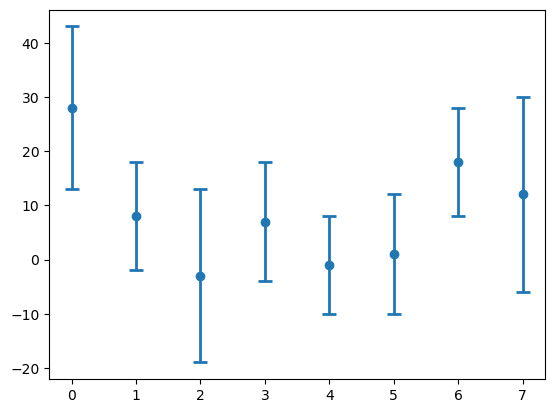

In [10]:
improvement = np.array([28, 8, -3, 7, -1, 1, 18, 12])
improvement_unc = np.array([15, 10, 16, 11, 9, 11, 10, 18])

fig, ax = plt.subplots()
ax.errorbar(
    np.arange(len(improvement)),
    improvement,
    yerr=improvement_unc,
    fmt="o",
    capsize=5,
    capthick=2,
    elinewidth=2,
)
plt.show()


In [11]:
# Pooled statistics:
weights = 1 / improvement_unc**2
pooled_mean = np.average(improvement, weights=weights)
pooled_unc = np.sqrt(1 / np.sum(weights))
print(f"Pooled stats: {pooled_mean:.2f} ± {pooled_unc:.2f}")

Pooled stats: 7.69 ± 4.07


In [12]:
import pymc3 as pm
import pymc3_ext as pmx

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


In [38]:
pm.__version__

'3.11.5'

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [score_offset, alpha_sigma, alpha_mu]


/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [score_offset, alpha_sigma, alpha_mu]


/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


<BarContainer object of 8 artists>

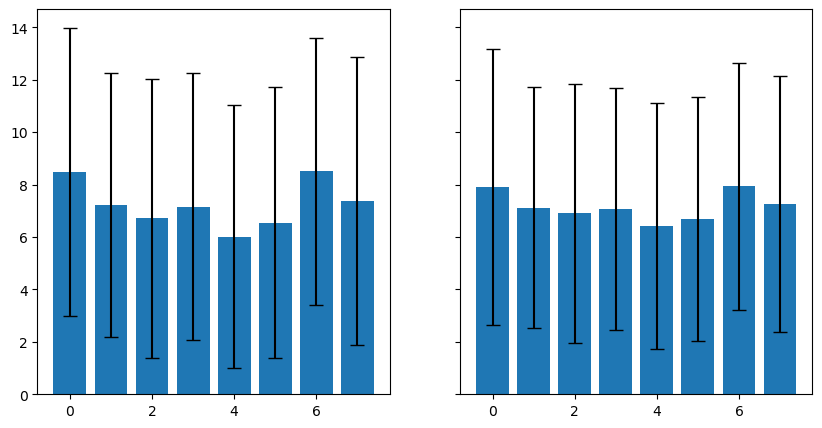

In [ ]:
with pm.Model() as model_normal:
    alpha_mu = pm.Normal("alpha_mu", mu=0, sd=15)
    alpha_sigma_normal = pm.HalfNormal("alpha_sigma", sigma=5)

    score_offset = pm.Normal("score_offset", mu=0, sd=1, shape=len(improvement))
    score_model_normal = pm.Deterministic(
        "score_model_normal", alpha_mu + alpha_sigma_normal * score_offset
    )

    lnl_normal = pm.Normal(
        "lnl", mu=score_model_normal, sd=improvement_unc, observed=improvement
    )

with pm.Model() as model_cauchy:
    alpha_mu = pm.Normal("alpha_mu", mu=0, sd=15)
    alpha_sigma_cauchy = pm.HalfCauchy("alpha_sigma", beta=2)
    score_offset = pm.Normal("score_offset", mu=0, sd=1, shape=len(improvement))
    score_model_cauchy = pm.Deterministic(
        "score_model_cauchy", alpha_mu + alpha_sigma_cauchy * score_offset
    )
    lnl_cauchy = pm.Normal(
        "lnl", mu=score_model_cauchy, sd=improvement_unc, observed=improvement
    )

with model_normal:
    trace_normal = pmx.sample(
        chains=4, tune=5000, draws=1000, target_accept=0.95, return_inferencedata=True
    )

with model_cauchy:
    trace_cauchy = pmx.sample(
        chains=4, tune=5000, draws=1000, target_accept=0.95, return_inferencedata=True
    )

<BarContainer object of 8 artists>

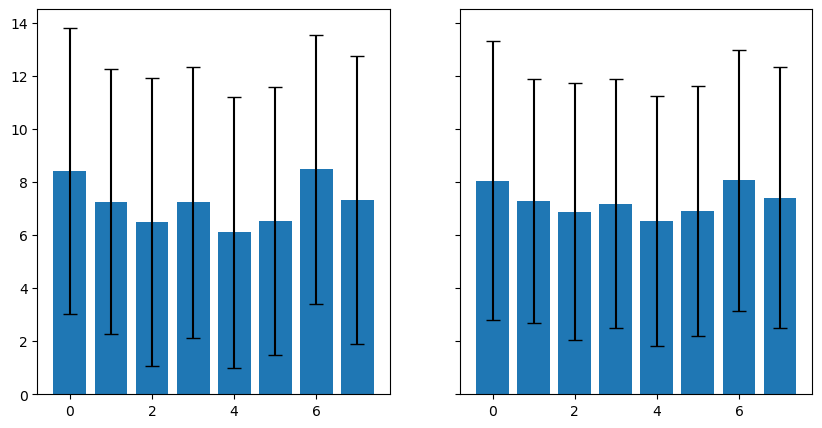

In [80]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))  
# ax[0].bar(np.arange(len(improvement)), improvement, yerr=improvement_unc, capsize=5)
ax[0].bar(
    np.arange(len(improvement)),
    trace_normal.posterior.score_model_normal.to_numpy().reshape(-1, 8).mean(axis=0),
    yerr=trace_normal.posterior.score_model_normal.to_numpy().reshape(-1, 8).std(axis=0),
    capsize=5,
)
ax[1].bar(
    np.arange(len(improvement)),
    trace_cauchy.posterior.score_model_cauchy.to_numpy().reshape(-1, 8).mean(axis=0),
    yerr=trace_cauchy.posterior.score_model_cauchy.to_numpy().reshape(-1, 8).std(axis=0),
    capsize=5,
)

<BarContainer object of 8 artists>

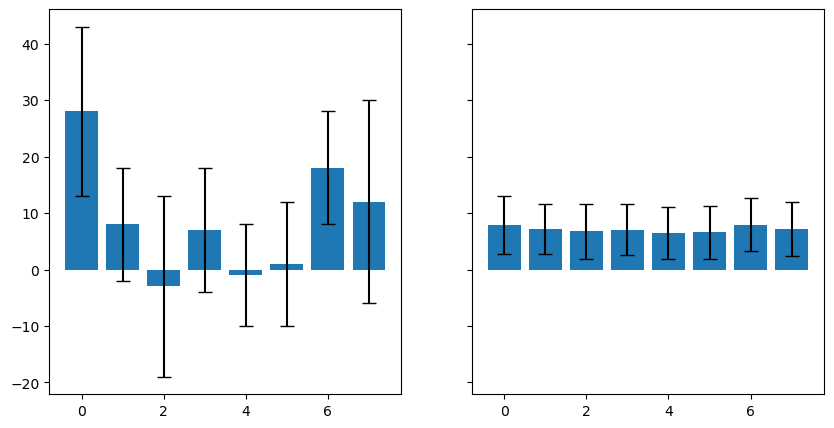

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))  
ax[0].bar(np.arange(len(improvement)), improvement, yerr=improvement_unc, capsize=5)
ax[1].bar(
    np.arange(len(improvement)),
    trace.posterior.score_model.to_numpy().reshape(-1, 8).mean(axis=0),
    yerr=trace.posterior.score_model.to_numpy().reshape(-1, 8).std(axis=0),
    capsize=5,
)

# Problem 2: The Five Districts

The test-prep program was expanded across five districts, for a total of 27 schools. For each school, the mean score improvement, uncertainty on the mean, and number of hours each student spent studying was recorded.

### Exercises

a) Load the Five Districts dataset (five_districts.csv) and plot the data
b) Determine the expected score improvement per hour studied for each school using three different models:

+ i. A fully pooled model
+ ii. Independent estimates for each district
+ iii. A hierarchical model that asserts a relationship between the schools and districts.

For all three cases, sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

For the third option, draw the relationship as a directed acyclic graph. Justify your choices of distributions for parameters and hyper-parameters, and test your results for sensitivity to modeling choices.


In [ ]:
data = np

# Problem 3: Dyson Spheres

Congratulations! You've detected a strange class of objects that you suspect are [Dyson spheres](https://en.wikipedia.org/wiki/Dyson_sphere). Your data are sparse, but you nonetheless detect hints of variability in each object's brightness.

a) Load the Dyson Sphere dataset (dyson_spheres.csv) and plot the time series data. What do you notice about the relative amplitude variations?

b) For each object, compute a Lomb-Scargle periodogram. What do you notice about the frequency-power plot?

c) Assume that each object's time series can be modeled as a single-component sinusoid. Construct a hierarchical model for the population, asserting some population-level relationship between the amplitudes, frequencies, and phases for each object's sinusoid. Which parameters might be expected to be correlated or independent of one another?

# Problem 4: Astrophysics

Select an astrophysical dataset of your choosing. Describe any hierarchical structure in the data using a directed acyclic graph. Build a simple hierarchical model for the data. You may wish to use only a few member objects of your dataset in order to more rapidly iterate while developing.